In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Импортируем библиотеки и модули

In [2]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Загружаем данные, делаем предобработку

In [3]:
# Загрузка данных
DATA_DIR = '/content/gdrive/MyDrive/датасеты/chest_xray/train'
CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 150

data = []

def create_data(): 
    for category in CATEGORIES: # для каждой категории
        path = os.path.join(DATA_DIR, category) # находим путь к изображениям
        class_num = CATEGORIES.index(category) # задаем номер класса (NORMAL - 0, PNEUMONIA - 1)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # читаем изображения в градации серого
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # меняем размер
                data.append([resized_array, class_num]) # добавляем в массив data изображение и класс
            except Exception as e:
                pass

create_data()
random.shuffle(data) # перемешиваем данные

In [4]:
counts = [] # счетчики фотографий
for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category) # путь к соответствующе папке с фотографиями
    count = len(os.listdir(path)) 
    counts.append(count)

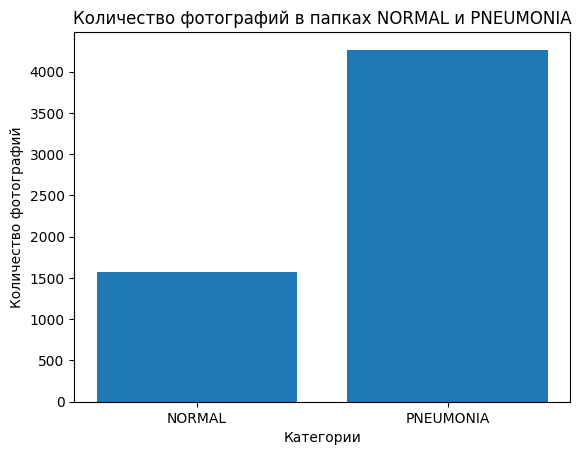

In [5]:
plt.bar(CATEGORIES, counts) # гистограмма
plt.title('Количество фотографий в папках NORMAL и PNEUMONIA')
plt.xlabel('Категории')
plt.ylabel('Количество фотографий')
plt.show()

Разделяем данные на тренировочную и тестовую выборку

In [6]:
# отделяем метки от изображений
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# преобразуем в массив numpy

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

# разделяем на обучающую и тестовую выборку 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# приводим все значения пикселей в диапазон между 0 и 1

X_train = X_train / 255.0
X_test = X_test / 255.0


Создаем CNN модель

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [9]:
from keras.metrics import Recall
import keras.backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

# Регистрация метрики
custom_objects = {'recall': recall, 'precision': precision, 'f1': f1}

keras.utils.get_custom_objects().update(custom_objects)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', f1, recall, precision])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

Определяем оптимальный размер пакетов и количество эпох с использованием Keras Callbacks для ранней остановки (EarlyStopping) и ImageDataGenerator для аугментации данных:

In [12]:
BATCH_SIZE = 32
EPOCHS = 50

# Аугментация данных
train_datagen = ImageDataGenerator(
    rotation_range=20, # поворот
    zoom_range=0.15, # масштаб
    width_shift_range=0.2, # смещение по горизонтали
    height_shift_range=0.2, # смещение по вертикали
    shear_range=0.15, # искривление
    horizontal_flip=True, # отражение по вертикали
    fill_mode="nearest") # заполнение близжайшими значениями

In [13]:
# Подготовка генератора данных
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)


In [14]:
# Callback для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Обучаем модель

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
146/146 [==============================] - 224s 2s/step - loss: 0.4141 - accuracy: 0.8333 - f1: 0.8760 - recall: 0.8386 - precision: 0.9263 - val_loss: 3.7423 - val_accuracy: 0.7440 - val_f1: 0.8509 - val_recall: 1.0000 - val_precision: 0.7449
Epoch 2/50
146/146 [==============================] - 232s 2s/step - loss: 0.2715 - accuracy: 0.8913 - f1: 0.9240 - recall: 0.9235 - precision: 0.9288 - val_loss: 2.4400 - val_accuracy: 0.7440 - val_f1: 0.8509 - val_recall: 1.0000 - val_precision: 0.7449
Epoch 3/50
146/146 [==============================] - 230s 2s/step - loss: 0.2509 - accuracy: 0.9005 - f1: 0.9311 - recall: 0.9388 - precision: 0.9277 - val_loss: 2.0151 - val_accuracy: 0.7440 - val_f1: 0.8509 - val_recall: 1.0000 - val_precision: 0.7449
Epoch 4/50
146/146 [==============================] - 230s 2s/step - loss: 0.2181 - accuracy: 0.9125 - f1: 0.9390 - recall: 0.9446 - precision: 0.9372 - val_loss: 1.0923 - val_accuracy: 0.7440 - val_f1: 0.8509 - val_recall: 1.0000 - va

KeyboardInterrupt: ignored

Строим графики accuracy, f1, recall, precision и loss

Оцениваем обученную модель на тестовом наборе данных



In [ ]:
# Оценка модели
loss, acc, f1, recall, precision = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test Accuracy:, {acc:.4f}")
print(f"Test F1-score:, {f1:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test Precision:, {precision:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric_list, title):
    """
    Функция для построения графиков метрик.

    Parameters:
        history (keras.callbacks.History): История обучения модели.
        metric_list (list): Список с именами метрик.
        title (str): Название графика.
    """
    epochs_range = range(1, len(history.history[metric_list[0]]) + 1)

    fig, axes = plt.subplots(nrows=len(metric_list), ncols=1, figsize=(8, 20))

    for i, metric in enumerate(metric_list):

        ax = axes[i]
        ax.set_title(metric)

        # График изменения на обучающих и проверочных данных
        train_metric = history.history[metric]
        val_metric = history.history['val_' + metric]

        ax.plot(epochs_range, train_metric, label='Training')
        ax.plot(epochs_range, val_metric, label='Validation')
        ax.legend(loc='lower right')

    plt.suptitle(title)
    plt.show()

In [ ]:
metric_list = ['accuracy', 'recall', 'precision', 'f1']

plot_metrics(history, metric_list, 'Training and Validation')